# 28批量归一化

## 批量归一化层
### 可学习的参数为y和β
### 作用在
######    全连接层和卷积层输出上，激活函数前
######    全连接层和卷积层输入上
### 对全连接层，作用在特征维
### 对于卷积层，作用在通道维

#### 批量归一化固定小批量中的均值和方差，然后学习出适合的偏移和缩放
#### 可以加速收敛速度，但一般不改变模型精度


从头开始实现一个具有张量的批量规范化层

In [17]:
import torch
from torch import nn
from d2l import torch as d2l

#激活层前 全连接层和卷积层输出后
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    # eps用于避免除0
    # moving_mean var 整个数据集上的均值和方差 momentum用于更新moving
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            # 二维的情况  批量 特征 特征是行 按行求
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            # 4 （批量0 通道1 高2 宽3）
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

通常情况下，我们用一个单独的函数定义其数学原理，比如说batch_norm。 然后，我们将此功能集成到一个自定义层中，其代码主要处理数据移动到训练设备（如GPU）、分配和初始化任何必需的变量、跟踪移动平均线（此处为均值和方差）等问题

In [18]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

使用批量规范化层的 LeNet

In [19]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

在Fashion-MNIST数据集上训练网络

loss 0.276, train acc 0.898, test acc 0.811
42840.9 examples/sec on cuda:0


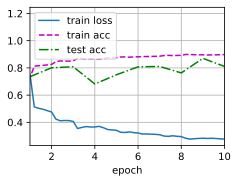

In [20]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

拉伸参数gamma和偏移参数beta

In [22]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1.4541, 4.2352, 0.3267, 3.3015, 2.8399, 0.5555], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 0.2174, -2.2757, -0.4292,  3.6019,  1.9209, -0.8963], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

# 简明实现

In [23]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

使用相同超参数来训练模型


loss 0.269, train acc 0.901, test acc 0.872
56284.9 examples/sec on cuda:0


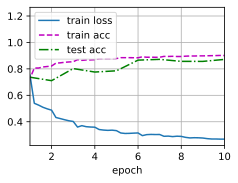

In [24]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

在模型训练过程中，批量规范化利用小批量的均值和标准差，不断调整神经网络的中间输出，使整个神经网络各层的中间输出值更加稳定。</br>
批量规范化在全连接层和卷积层的使用略有不同。</br>
批量规范化层和暂退层一样，在训练模式和预测模式下计算不同。</br>
批量规范化有许多有益的副作用，主要是正则化。另一方面，"减少内部协变量偏移"的原始动机似乎不是一个有效的解释。